### 모듈, 패키지 로딩

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [2]:
import matplotlib
import matplotlib.pyplot as plt  # 파이플롯 사용
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')  # 한글코드를 더 선명하게 해주는 조치, 레티나 설정
matplotlib.rc('font', family='AppleGothic') # 폰트 설정
matplotlib.rc('axes', unicode_minus=False) # 마이너스 폰트가 깨지는 경우가 있으므로 조치


### 학습 테스트 데이터 로딩

- 당사자종별을 1당/2당으로 표기한 데이터가 있고 (2012_2014, 2016,2017) 가해자/피해자로 표기한 데이터가 있다 (2015, 2018)
- 피쳐 데이터 : 발생시(hour), 도로형태, 발생지시군구, 사고유형_중분류, 가해자_당사자종별(1당), 피해자_당사자종별(2당)

In [3]:
car_acc_2012_2014 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2012_2014.csv', encoding='euc-kr', engine='python')
car_acc_2012_2014.shape


(14624, 27)

In [4]:
car_acc_2015 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2015.csv', encoding='euc-kr', engine='python')
car_acc_2015.shape

(4447, 26)

In [5]:
car_acc_2016 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2016.csv', encoding='euc-kr', engine='python')
car_acc_2016.shape

(4119, 27)

In [6]:
car_acc_2017 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2017.csv', encoding='euc-kr', engine='python')
car_acc_2017.shape

(4065, 27)

In [7]:
car_acc_2018 = pd.read_csv('/Users/taewoongkong/workspace/pandas_public_data/car_acc_2018.csv', encoding='euc-kr', engine='python')
car_acc_2018.shape

(3657, 26)

In [8]:
#당사자종별을 1당/2당으로 표기한 데이터가 있고 (2012_2014, 2016,2017) 가해자/피해자로 표기한 데이터가 있다 (2015, 2018)

car_acc_2012_2014['가해자_당사자종별'] = car_acc_2012_2014['당사자종별_1당']
car_acc_2012_2014['피해자_당사자종별'] = car_acc_2012_2014['당사자종별_2당']

car_acc_2016['가해자_당사자종별'] = car_acc_2016['당사자종별_1당']
car_acc_2016['피해자_당사자종별'] = car_acc_2016['당사자종별_2당']

car_acc_2017['가해자_당사자종별'] = car_acc_2017['당사자종별_1당']
car_acc_2017['피해자_당사자종별'] = car_acc_2017['당사자종별_2당']


### 전처리

- 피쳐데이터로 쓸 것만 남기기 (레이블 데이터인 사망자수도 일단 포함)
- concat
- 발생시hour 변환 작업
- 발생시도 + 발생시군구를 합치기
- 사망자수 1 or 다수로 2분할 (0 - 1명 사망 , 1 - 다수 사망)
- 각 피쳐 null 처리 및 피쳐 엔지니어링


In [9]:
ftr_columns = ['발생년월일시', '발생지시도', '발생지시군구', '사고유형_중분류', '가해자_당사자종별', '피해자_당사자종별', '사망자수']

In [10]:
# 발생년월일시분이라고 저장된 데이터셋은 따로 처리
car_acc_2015['발생년월일시'] = car_acc_2015['발생년월일시분']
car_acc_2018['발생년월일시'] = car_acc_2018['발생년월일시분']

In [11]:
# 필요한 피쳐만 남겨서 새로운 데이터프레임에 저장

car_acc_2012_2014_ftr = car_acc_2012_2014[ftr_columns]
car_acc_2015_ftr = car_acc_2015[ftr_columns]
car_acc_2016_ftr = car_acc_2016[ftr_columns]
car_acc_2017_ftr = car_acc_2017[ftr_columns]
car_acc_2018_ftr = car_acc_2018[ftr_columns]

In [12]:
# concat

car_acc_ftr = pd.concat([car_acc_2012_2014_ftr, 
                         car_acc_2015_ftr, 
                         car_acc_2016_ftr, 
                         car_acc_2017_ftr, 
                         car_acc_2018_ftr], sort = False)
car_acc_ftr.tail()

,발생년월일시,발생지시도,발생지시군구,사고유형_중분류,가해자_당사자종별,피해자_당사자종별,사망자수
3652,2018-05-21 03:55,경기,포천시,공작물충돌,승용차,없음,1
3653,2018-06-08 08:43,경기,포천시,추돌,화물차,농기계,1
3654,2018-01-20 10:15,경기,가평군,공작물충돌,승용차,없음,1
3655,2018-02-03 21:05,경기,가평군,정면충돌,승용차,승용차,1
3656,2018-12-03 10:05,경기,연천군,측면충돌,승용차,승용차,1


In [13]:
# hour 변환 - null값 없음 확인

car_acc_ftr['발생시'] = pd.to_datetime(car_acc_ftr['발생년월일시'])
car_acc_ftr['발생시'] = car_acc_ftr['발생시'].dt.hour

In [14]:
car_acc_ftr['발생지'] = car_acc_ftr['발생지시도'] + '-' + car_acc_ftr['발생지시군구']

In [15]:
car_acc_ftr = car_acc_ftr.drop(['발생지시도', '발생지시군구'], axis = 1)

In [16]:
def 사망자수_이진분류(count):
    if count == 1:
        return 0
    else:
        return 1

#### 가해자 데이터 전처리

- 경형 -> 소형 으로 편입
- 원동기장치자전거 -> 이륜차로 편입
- 사발이, 사륜오토바이 -> 이륜차로 편입
- 승합차 -> 대형으로 편입
- 특수차, 불명, 개인형이동수단, 기타 -> 기타로 편입

In [17]:
# 가해자_당사자종별 데이터 전처리

car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '경형', '가해자_당사자종별'] = '소형'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '원동기장치자전거', '가해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '사발이', '가해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '사륜오토바이(ATV)', '가해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '승합차', '가해자_당사자종별'] = '대형'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '특수차', '가해자_당사자종별'] = '기타'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '불명', '가해자_당사자종별'] = '기타'
car_acc_ftr.loc[car_acc_ftr['가해자_당사자종별'] == '개인형이동수단(PM)', '가해자_당사자종별'] = '기타'



#### 피해자 데이터 전처리

- 00 -> 대물사고 로 구체화
- 없음 -> 대물사고로 구체화
- 경형 -> 소형 으로 편입
- 원동기장치자전거 -> 이륜차로 편입
- 사발이, 사륜오토바이 -> 이륜차로 편입
- 승합차 -> 대형으로 편입
- 불명 -> 보행자로 편입
- 특수차, 개인형이동수단, 기타 -> 기타로 편입

In [18]:
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '00', '피해자_당사자종별'] = '대물사고'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '없음', '피해자_당사자종별'] = '대물사고'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '경형', '피해자_당사자종별'] = '소형'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '승합차', '피해자_당사자종별'] = '대형'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '원동기장치자전거', '피해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '사발이', '피해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '사륜오토바이(ATV)', '피해자_당사자종별'] = '이륜차'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '특수차', '피해자_당사자종별'] = '기타'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '불명', '피해자_당사자종별'] = '기타'
car_acc_ftr.loc[car_acc_ftr['피해자_당사자종별'] == '열차', '피해자_당사자종별'] = '기타'


#### 사고유형_중분류 데이터 전처리

- 전도 -> 전도전복 으로 편입
- 전복 -> 전도전복 으로 편입
- 차도, 보도통행중 -> 횡단중 으로 편입
- 직전진행, 경보기무시, 차단기돌파, 철길건널목 -> 기타로 편입


In [19]:
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '전도', '사고유형_중분류'] = '전도전복'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '전복', '사고유형_중분류'] = '전도전복'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '차도통행중', '사고유형_중분류'] = '횡단중'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '보도통행중', '사고유형_중분류'] = '횡단중'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '직전진행', '사고유형_중분류'] = '기타'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '경보기무시', '사고유형_중분류'] = '기타'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '차단기돌파', '사고유형_중분류'] = '기타'
car_acc_ftr.loc[car_acc_ftr['사고유형_중분류'] == '철길건널목', '사고유형_중분류'] = '기타'


In [20]:
car_acc_ftr['사망자수_타겟값'] = car_acc_ftr['사망자수'].apply(사망자수_이진분류)

In [21]:
car_acc_ftr = car_acc_ftr.drop(['사망자수', '발생년월일시'], axis =1)

In [22]:
car_acc_ftr['사망자수_타겟값'].value_counts()

0    29916
1      996
Name: 사망자수_타겟값, dtype: int64

In [22]:
car_acc_ftr

,사고유형_중분류,가해자_당사자종별,피해자_당사자종별,발생시,발생지,사망자수_타겟값
0,추돌,대형,대형,1,경남-거창군,0
1,추돌,소형,소형,13,경기-용인시,0
2,측면직각충돌,중형,소형,20,경북-김천시,0
3,추돌,대형,소형,14,경기-이천시,0
4,추돌,대형,대형,4,전남-광양시,0
...,...,...,...,...,...,...
3652,공작물충돌,승용차,대물사고,3,경기-포천시,0
3653,추돌,화물차,농기계,8,경기-포천시,0
3654,공작물충돌,승용차,대물사고,10,경기-가평군,0
3655,정면충돌,승용차,승용차,21,경기-가평군,0


In [23]:
#car_acc_ftr = car_acc_ftr.drop('발생지', axis=1)

## 머신러닝 학습 진행 (랜덤포레스트)

### 원핫인코딩

In [23]:
X_df = car_acc_ftr.iloc[:,:-1]
y_df = car_acc_ftr.iloc[:,-1]

In [24]:
X_features_ohe = pd.get_dummies(X_df, columns=X_df.columns)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_df, test_size=0.2, random_state=11)

In [26]:
y_test.value_counts()

0    5976
1     207
Name: 사망자수_타겟값, dtype: int64

In [29]:
y_train.value_counts()

0    23940
1      789
Name: 사망자수_타겟값, dtype: int64

In [30]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test , rf_pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(rf_accuracy))


랜덤 포레스트 정확도: 0.9652
RandomForestClassifier 기본 하이퍼 파라미터:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [32]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test, pred=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    #roc_auc = roc_auc_score(y_test, pred_proba)
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}'.format(accuracy, precision, recall, f1))

get_clf_eval(y_test, rf_pred)

[[5966   10]
 [ 205    2]]
정확도: 0.9652, 정밀도: 0.1667, 재현율: 0.0097,    F1: 0.0183


## 피쳐엔지니어링 (뻥튀기)

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)  # 사이킷런 fit 아닙니다
# 디폴트가 0.3으로 쪼개짐

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)

# _over : 오버 샘플링 적용
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (24729, 290) (24729,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (47880, 290) (47880,)
SMOTE 적용 후 레이블 값 분포: 
 1    23940
0    23940
Name: 사망자수_타겟값, dtype: int64


In [45]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train_over , X_train_over)
rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test , rf_pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(rf_accuracy))

print('RandomForestClassifier 기본 하이퍼 파라미터:\n', rf_clf.get_params())

랜덤 포레스트 정확도: 0.9332
RandomForestClassifier 기본 하이퍼 파라미터:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [46]:
get_clf_eval(y_test, rf_pred)

오차 행렬
[[5756  220]
 [ 193   14]]
정확도: 0.9332, 정밀도: 0.0598, 재현율: 0.0676


In [56]:
f1 = f1_score(y_test, rf_pred)
print(f1)

0.06349206349206349


### 정리



그럼 정확도가 높은 이유는 무엇인가?

알고리즘이 워낙 1인 사망(N)이 많이 나오다보니 N으로 계속 판단하고 있다 -> 그러니 정확도는 높은 편

그러다 가끔 나오는 다인 사망 (P)이 나오면 쉽게 틀린다. -> 근데 그 경우가 워낙 적으니 정확도는 높게 나온다.

다인사망이 나왔을 때 알고리즘이 헛다리를 자주 짚는다
- SMOTE 전 : 정확도: 0.9615, 정밀도: 0.0811, 재현율: 0.0145
- SMOTE 후 : 정확도: 0.9332, 정밀도: 0.0598, 재현율: 0.0676

이 상황에서 정밀도가 낮아졌다는 건 SMOTE로 인해 다인 사망(Positive)이 데이터셋에 늘어나서, 다인사망 상황이 생각보다 잦네? 라고 인식한 알고리즘이 P판정을 늘리다보니 진짜 다인사망 데이터 나왔을 때 맞추긴 하니까_TP 높음 // 반대로 FP 개많아서 정밀도 딱락)

이 상황에서 재현율이 올라갔다는 건 SMOTE 로 데이터가 늘어나 그래도 다인 사망 상황을 제법 잘 맞추고 있다는 뜻이기도 ?


- SMOTE 전 f1: 0.0182648401826484
- SMOTE 후 f1: 0.06349206349206349

f1스코어는 비약적으로 올라갔다 (무려 6배 ㅋㅋㅋㅋ)


In [50]:
y_train_over.value_counts()

1    23940
0    23940
Name: 사망자수_타겟값, dtype: int64

In [51]:
y_train.value_counts()

0    23940
1      789
Name: 사망자수_타겟값, dtype: int64

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)


get_clf_eval(y_test, dt_pred)

오차 행렬
[[5935   41]
 [ 204    3]]
정확도: 0.9604, 정밀도: 0.0682, 재현율: 0.0145


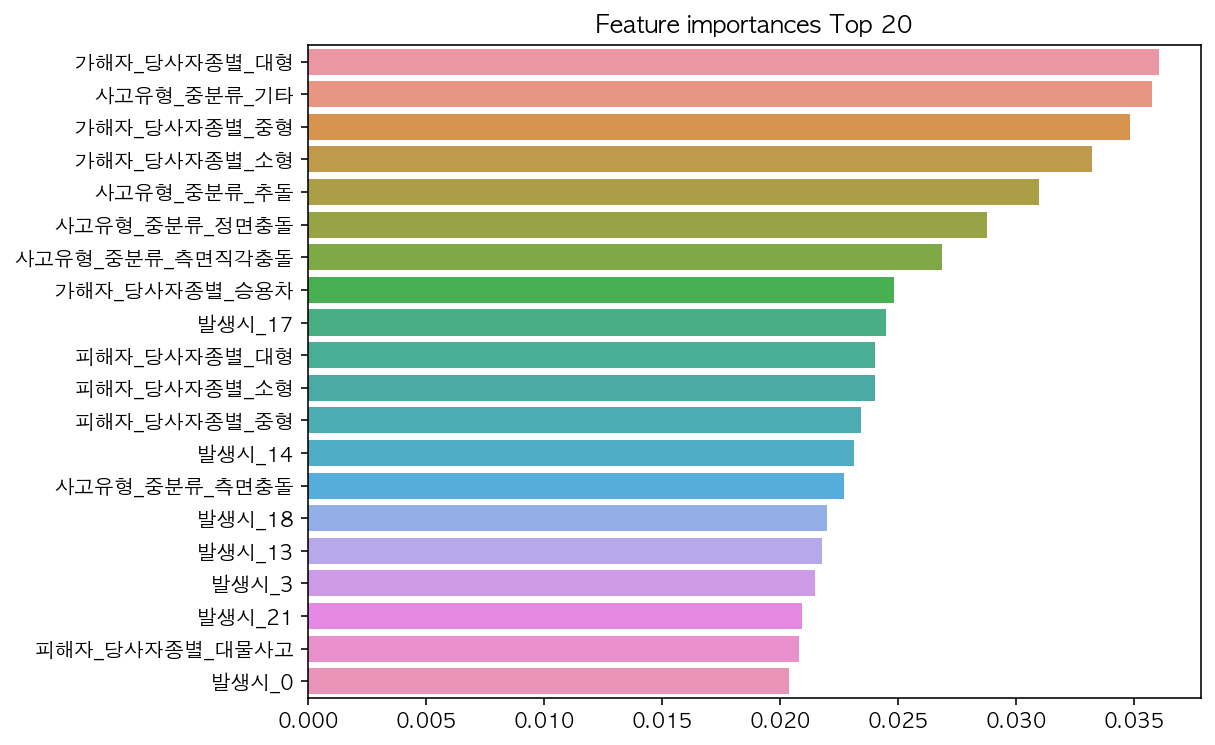

In [40]:
ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [28]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test , rf_pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(rf_accuracy))

print('RandomForestClassifier 기본 하이퍼 파라미터:\n', rf_clf.get_params())

랜덤 포레스트 정확도: 0.9652
RandomForestClassifier 기본 하이퍼 파라미터:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [29]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [30]:
get_clf_eval(y_test, rf_pred)

오차 행렬
[[5966   10]
 [ 205    2]]
정확도: 0.9652, 정밀도: 0.1667, 재현율: 0.0097


In [31]:
f1 = f1_score(y_test, rf_pred)
print(f1)

0.0182648401826484


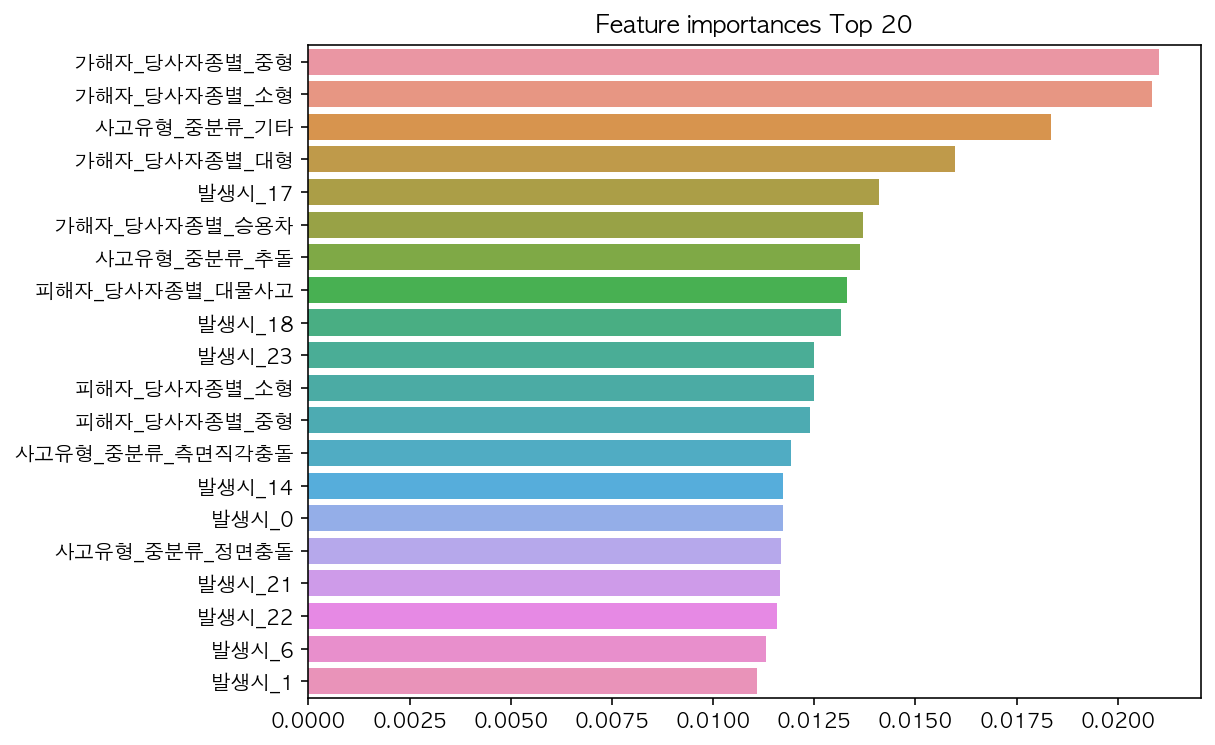

In [31]:
ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [61]:
X_train.columns = range(58)

In [68]:
X_test.columns = range(58)

In [75]:
X_train_over.columns = range(58)


## LightGBM 가즈아

In [76]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_train_over, y_train_over)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)

lgbm_preds = lgbm_clf.predict(X_test)

get_clf_eval(y_test , lgbm_preds)


[1]	valid_0's auc: 0.761897	valid_0's binary_logloss: 1.68205
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.770123	valid_0's binary_logloss: 1.64094
[3]	valid_0's auc: 0.774909	valid_0's binary_logloss: 1.60919
[4]	valid_0's auc: 0.781483	valid_0's binary_logloss: 1.58301
[5]	valid_0's auc: 0.784972	valid_0's binary_logloss: 1.56165
[6]	valid_0's auc: 0.788378	valid_0's binary_logloss: 1.54392
[7]	valid_0's auc: 0.792652	valid_0's binary_logloss: 1.52902
[8]	valid_0's auc: 0.795968	valid_0's binary_logloss: 1.51606
[9]	valid_0's auc: 0.798734	valid_0's binary_logloss: 1.50503
[10]	valid_0's auc: 0.79899	valid_0's binary_logloss: 1.4949
[11]	valid_0's auc: 0.799877	valid_0's binary_logloss: 1.48577
[12]	valid_0's auc: 0.801812	valid_0's binary_logloss: 1.47886
[13]	valid_0's auc: 0.80099	valid_0's binary_logloss: 1.47147
[14]	valid_0's auc: 0.802884	valid_0's binary_logloss: 1.46561
[15]	valid_0's auc: 0.807213	valid_0's binary_logloss: 1.4591
[16]	v